In [1]:
# -*- coding:utf8 -*-
import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from mydatools.plot import plot_grid_search_result

% matplotlib inline

## 获取数据

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

id  is_duplicate  qid1  qid2  \
train 0  0.0           0.0   1.0   2.0   
      1  1.0           0.0   3.0   4.0   
      2  2.0           0.0   5.0   6.0   
      3  3.0           0.0   7.0   8.0   
      4  4.0           0.0   9.0  10.0   

                                                 question1  \
train 0  What is the step by step guide to invest in sh...   
      1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
      2  How can I increase the speed of my internet co...   
      3  Why am I mentally very lonely? How can I solve...   
      4  Which one dissolve in water quikly sugar, salt...   

                                                 question2  test_id  
train 0  What is the step by step guide to invest in sh...      NaN  
      1  What would happen if the Indian government sto...      NaN  
      2  How can Internet speed be increased by hacking...      NaN  
      3  Find the remainder when [math]23^{24}[/math] i...      NaN  
      4            Which fish would survive in salt water?      NaN

In [39]:
feature_set = set()

## 相同words的占比 

两个问题所含有的相同单词占比越多，它们之间就越相似
即question1有的单词为qs1_words，question2有的单词为qs2_words，共有的单词为share_words
qs1_words[k][i]代表第k条数据是否有第i个单词

$similarity = \frac{\sum\limits_{i} share\_words[i]}{\sum\limits_{i} qs1\_words[i] + \sum\limits_{i} qs2\_words[i]}$

上式没有对单词赋权，实际上不同的单词相同会有不同效果，比如like这种经常出现的单词，权值应该较低
所以，对上式进行修改，weight由tfidf得出

$similarity = \frac{\sum\limits_{i} share\_words[i] * weight[i]}{\sum\limits_{i} qs1\_words[i] * weight[i] + \sum\limits_{i} qs2\_words[i] * weight[i]}$

In [3]:
# 获取所有question
qs1 = full_df['question1'].values.astype('U').tolist()
qs2 = full_df['question2'].values.astype('U').tolist()

In [4]:
# 对所有question进行tfidf
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(qs1 + qs2)
pd.DataFrame([tfidf.idf_], columns=tfidf.get_feature_names())

,00,000,0000,000000,0000000,00000000,0000000000,00000000000000000000,0000001,00000074,...,이정현,이주일이,충만해서,친구해도,쾌지나칭칭나네,하지만,한글,황경지,ﬁnd,ｦb
0,9.74721,7.313857,13.301414,14.57438,14.728531,15.827143,15.421678,14.57438,15.827143,15.827143,...,15.421678,13.955341,14.57438,15.827143,14.323066,15.421678,15.421678,14.57438,15.421678,13.881233


In [5]:
# question1 question2 存在的words
qs1_words = (tfidf.transform(qs1) > 0).astype('int')
qs2_words = (tfidf.transform(qs2) > 0).astype('int')

In [6]:
# question1 question2 共有的words
share_words = ((qs1_words + qs2_words) == 2).astype('int')

In [7]:
# 共有单词权值和
share_weight = share_words.multiply(tfidf.idf_).sum(axis=1)

In [8]:
# 总体单词权值和
total_weight = (qs1_words + qs2_words).multiply(tfidf.idf_).sum(axis=1)

In [30]:
# 没有权重的相似度
full_df['question_word_similarity'] = share_words.sum(axis=1) / (qs1_words + qs2_words).sum(axis=1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [9]:
# 带tfidf权重的相似度
full_df['question_tfidf_similarity'] = share_weight / total_weight

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


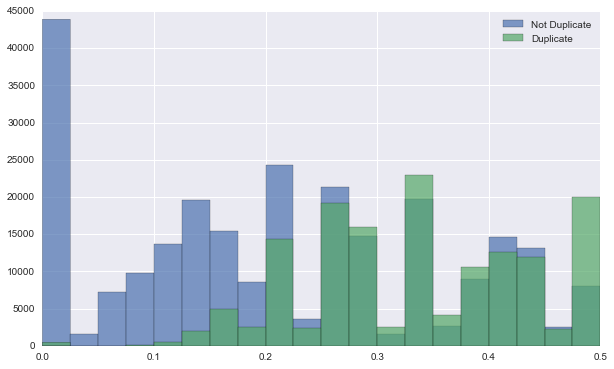

In [31]:
plt.subplots(1,1,figsize=(10,6))
plt.hist(full_df[full_df['is_duplicate'] == 0]['question_word_similarity'].fillna(0), bins=20, alpha=0.7, label='Not Duplicate')
plt.hist(full_df[full_df['is_duplicate'] == 1]['question_word_similarity'].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()

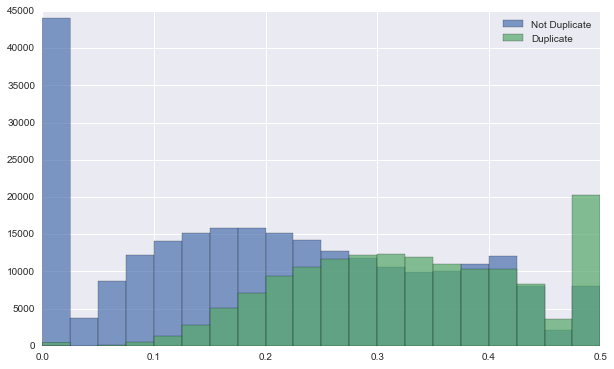

In [29]:
plt.subplots(1,1,figsize=(10,6))
plt.hist(full_df[full_df['is_duplicate'] == 0]['question_tfidf_similarity'].fillna(0), bins=20, alpha=0.7, label='Not Duplicate')
plt.hist(full_df[full_df['is_duplicate'] == 1]['question_tfidf_similarity'].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()

In [40]:
feature_set.update(['question_word_similarity', 'question_tfidf_similarity'])

## 预处理

In [42]:
feature_columns = list(feature_set)
label_column = 'is_duplicate'

In [43]:
X_train = full_df.loc['train'][feature_columns].values
y_train = full_df.loc['train'][label_column].values

X_pred = full_df.loc['test'][feature_columns].values

## XGBoost

In [44]:
import xgboost as xgb

In [45]:
xg_train = xgb.DMatrix(X_train, y_train)
xg_pred = xgb.DMatrix(X_pred)

In [49]:
bst_paras = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
#     'n_estimators': 1000,
#     'eta': 0.1,
    'eta': 0.05,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'max_depth': 5,
}
num_boost_round = 1000

In [50]:
xgb_cv_res = xgb.cv(bst_paras, xg_train, num_boost_round, nfold=5, stratified=True, early_stopping_rounds=20, verbose_eval=25)
best_round = np.argmin(xgb_cv_res['test-logloss-mean'])
print('best_model:', xgb_cv_res.iloc[best_round])

[0]	train-logloss:0.687904+1.36294e-05	test-logloss:0.687908+2.73101e-05
[25]	train-logloss:0.60325+0.000172096	test-logloss:0.603317+0.000432499
[50]	train-logloss:0.564309+0.000248485	test-logloss:0.56441+0.000690687
[75]	train-logloss:0.544616+0.000332805	test-logloss:0.544761+0.000833918
[100]	train-logloss:0.534233+0.000362751	test-logloss:0.534439+0.000952675
[125]	train-logloss:0.528685+0.00034661	test-logloss:0.528925+0.00105918
[150]	train-logloss:0.525536+0.000338384	test-logloss:0.525811+0.00113107
[175]	train-logloss:0.523652+0.000303976	test-logloss:0.523968+0.00119116
[200]	train-logloss:0.522481+0.000296368	test-logloss:0.522832+0.00122087
[225]	train-logloss:0.521674+0.000293734	test-logloss:0.522063+0.00124848
[250]	train-logloss:0.521142+0.000285952	test-logloss:0.521566+0.00126901
[275]	train-logloss:0.520706+0.000264153	test-logloss:0.521174+0.00129285
[300]	train-logloss:0.520202+0.000273261	test-logloss:0.520718+0.00127438
[325]	train-logloss:0.519752+0.000282727	

In [51]:
bst = xgb.train(bst_paras, xg_train, best_round)
print('train_loss:', metrics.log_loss(y_train, bst.predict(xg_train)))

train_loss: 0.51586448311


## 预测

In [64]:
res_df.to_csv('./data/output/result.csv', index=False)

In [ ]:
# 选择模型 并预测
model = bst
pred_proba = model.predict(xgb.DMatrix(X_pred))

# 结果df
res_df = pd.DataFrame({
    'test_id': full_df.loc['test']['test_id'].astype('int'),
    'is_duplicate': pred_proba,
}, columns=['test_id', 'is_duplicate'])

# save as csv
res_df.to_csv('./data/output/result.csv', index=False)

# zip
# import zipfile
# with zipfile.ZipFile('./data/output/result.zip', 'w') as f:
#     f.write('./data/output/result.csv')